In [1]:
# Imports
import numpy as np
from scipy import integrate
from tqdm import tqdm
from scipy.special import jv
import matplotlib.pyplot as plt
from numba import jit
import pickle
import os
import warnings
from multiprocessing import Pool, cpu_count
from functools import lru_cache
warnings.filterwarnings("ignore")

In [2]:
@jit(nopython=True)
def cutoff_cos(t, tau):
    """
    Computes a cosine taper cutoff function to smoothly transition the integrand
    from 1 to 0, used to model the finite duration of bubble wall interactions
    during the collision in a first-order phase transition.

    Args:
    - t (float): Time variable during the bubble collision.
    - tau (float): Cutoff time, defining the duration of the collision dynamics.

    Returns:
    - float: Cutoff value, 1 for t <= 0.9*τ, smoothly transitions to 0 
    between 0.9*τ and τ using a cosine taper, and 0 for t > τ.
    """
    tau_c = 0.9 * tau
    if 0 <= t <= tau_c:
        return 1.0
    elif tau_c <= t <= tau:
        # Smooth cosine transition in the last 10% of the time domain
        return 0.5 * (1 + np.cos(np.pi * (t - tau_c) / (0.1 * tau)))
    else:
        return 0.0

@jit(nopython=True)
def cutoff(t, tau):
    """
    Computes a Gaussian cutoff function to smoothly transition the integrand
    from 1 to 0, using an exponential decay in the final 10% of the time domain.

    Args:
    - t (float): Time variable during the bubble collision.
    - tau (float): Cutoff time, defining the duration of the collision dynamics.

    Returns:
    - float: Cutoff value, 1 for t <= 0.9*τ, exponential decay for 
    0.9*τ < t <= τ, and 0 for t > τ.
    """
    tau_c = 0.9 * tau
    if 0 <= t <= tau_c:
        return 1.0
    elif tau_c < t <= tau:
        # Exponential decay with Gaussian profile
        return np.exp(-((t - tau_c) / (0.025 * tau))**2)
    else:
        return 0.0

@jit(nopython=True)
def exclude_angle(t, d, vW):
    """
    Calculates the excluded angle alpha(t) based on geometric constraints of the
    bubble collision, used to limit the angular integration range.

    Args:
    - t (float): Time variable during the bubble collision.
    - d (float): Bubble separation distance along the z-axis.
    - vW (float): Bubble wall velocity (normalized, e.g., close to speed of light = 1).

    Returns:
    - float: Excluded angle in radians, arccos(d/(2*vW*t)) for t > d/(2*vW), otherwise 0.
    """
    threshold = d / (2 * vW)
    if t > threshold:
        return np.arccos(d / (2 * vW * t))
    else:
        return 0.0
    
@jit(nopython=True)
def base_values(t, d, vW, omega, psi):
    """
    Computes the base values for the gravitational wave response at a given time t
    for faster computation.

    Returns:
    - tuple: Base values for further calculations.
        - theta (np.ndarray): Array of angles for integration.
        - sin_theta (np.ndarray): Sine of angles for integration.
        - cos_theta (np.ndarray): Cosine of angles for integration.
        - trig_arg (np.ndarray): Argument for trigonometric functions.
        - bessel_arg (np.ndarray): Argument for Bessel functions.
    """
    # Calculate upper integration limit based on excluded angle
    upper_limit = np.pi - exclude_angle(t, d, vW)
    
    if upper_limit <= 0:
        return None
    
    # Adaptive number of integration points based on the angular range
    n_points = min(100, max(50, int(upper_limit * 50)))
    theta = np.linspace(0, upper_limit, n_points)
    
    # Precompute trigonometric functions for efficiency
    sin_theta = np.sin(theta)
    cos_theta = np.cos(theta)
    
    # Precompute omega-dependent terms
    omega_cos_psi = omega * np.cos(psi)
    omega_sin_psi = omega * np.sin(psi)
    
    # Arguments for trigonometric and Bessel functions
    trig_arg = omega_cos_psi * vW * t * cos_theta + 0.5 * omega_cos_psi * d
    bessel_arg = omega_sin_psi * vW * t * sin_theta
    
    return theta, sin_theta, cos_theta, trig_arg, bessel_arg

def inner_txx(t, omega, psi, vW, d):
    """
    Computes the inner angular integral over theta for the Txx component of the
    stress-energy tensor in the gravitational wave calculation.

    Args:
    - t (float): Time variable during the bubble collision.
    - omega (float): Angular frequency of the gravitational wave.
    - psi (float): Azimuthal angle defining the direction k̂ = ω (sin ψ, 0, cos ψ).
    - vW (float): Bubble wall velocity (normalized, e.g., close to speed of light = 1).
    - d (float): Bubble separation distance along the z-axis.

    Returns:
    - float: Value of the inner integral over theta, representing the angular contribution to the Txx component at time t.
    """
    # Precompute base values for efficiency
    base_vals = base_values(t, d, vW, omega, psi)
    if base_vals is None:
        return 0.0
    
    theta, sin_theta, cos_theta, trig_arg, bessel_arg = base_vals
    
    # Bessel function difference: J_0 - J_2
    bessel_0 = jv(0, bessel_arg)
    bessel_2 = jv(2, bessel_arg)
    bessel_diff = bessel_0 - bessel_2
    
    # Use JIT-compiled integration kernel
    return _integrate_txx_kernel(sin_theta, trig_arg, bessel_diff, theta)

@jit(nopython=True)
def _integrate_txx_kernel(sin_theta, trig_arg, bessel_diff, theta):
    """JIT-compiled integration kernel for Txx component."""
    # Integrand: geometric factor * phase factor * Bessel contribution
    integrand = sin_theta**3 * np.cos(trig_arg) * bessel_diff
    
    # Numerical integration using trapezoidal rule
    return np.trapz(integrand, theta)

def inner_tyy(t, omega, psi, vW, d):
    """
    Computes the inner angular integral over theta for the Tyy component of the
    stress-energy tensor in the gravitational wave calculation.

    Args:
    - t (float): Time variable during the bubble collision.
    - omega (float): Angular frequency of the gravitational wave.
    - psi (float): Azimuthal angle defining the direction k̂ = ω (sin ψ, 0, cos ψ).
    - vW (float): Bubble wall velocity (normalized, e.g., close to speed of light = 1).
    - d (float): Bubble separation distance along the z-axis.

    Returns:
    - float: Value of the inner integral over theta, representing the angular contribution to the Tyy component at time t.
    """
    # Precompute base values for efficiency
    base_vals = base_values(t, d, vW, omega, psi)
    if base_vals is None:
        return 0.0
    
    theta, sin_theta, cos_theta, trig_arg, bessel_arg = base_vals
    
    # Bessel function sum: J_0 + J_2
    bessel_0 = jv(0, bessel_arg)
    bessel_2 = jv(2, bessel_arg)
    bessel_sum = bessel_0 + bessel_2
    
    # Use JIT-compiled integration kernel
    return _integrate_tyy_kernel(sin_theta, trig_arg, bessel_sum, theta)

@jit(nopython=True)
def _integrate_tyy_kernel(sin_theta, trig_arg, bessel_sum, theta):
    """JIT-compiled integration kernel for Tyy component."""
    # Integrand: geometric factor * phase factor * Bessel contribution
    integrand = sin_theta**3 * np.cos(trig_arg) * bessel_sum
    
    # Numerical integration using trapezoidal rule
    return np.trapz(integrand, theta)

def inner_tzz(t, omega, psi, vW, d):
    """
    Computes the inner angular integral over theta for the Tzz component of the
    stress-energy tensor in the gravitational wave calculation.

    Args:
    - t (float): Time variable during the bubble collision.
    - omega (float): Angular frequency of the gravitational wave.
    - psi (float): Azimuthal angle defining the direction k̂ = ω (sin ψ, 0, cos ψ).
    - vW (float): Bubble wall velocity (normalized, e.g., close to speed of light = 1).
    - d (float): Bubble separation distance along the z-axis.

    Returns:
    - float: Value of the inner integral over theta, representing the angular contribution to the Tzz component at time t.
    """
    # Precompute base values for efficiency
    base_vals = base_values(t, d, vW, omega, psi)
    if base_vals is None:
        return 0.0
    
    theta, sin_theta, cos_theta, trig_arg, bessel_arg = base_vals
    
    # Bessel function J_0
    bessel_val = jv(0, bessel_arg)
    
    # Use JIT-compiled integration kernel
    return _integrate_tzz_kernel(sin_theta, cos_theta, trig_arg, bessel_val, theta)

@jit(nopython=True)
def _integrate_tzz_kernel(sin_theta, cos_theta, trig_arg, bessel_val, theta):
    """JIT-compiled integration kernel for Tzz component."""
    # Integrand: geometric factor * phase factor * Bessel contribution
    integrand = 2 * sin_theta * cos_theta**2 * np.cos(trig_arg) * bessel_val
    
    # Numerical integration using trapezoidal rule
    return np.trapz(integrand, theta)

def inner_txz(t, omega, psi, vW, d):
    """
    Computes the inner angular integral over theta for the Txz component of the
    stress-energy tensor in the gravitational wave calculation.

    Args:
    - t (float): Time variable during the bubble collision.
    - omega (float): Angular frequency of the gravitational wave.
    - psi (float): Azimuthal angle defining the direction k̂ = ω (sin ψ, 0, cos ψ).
    - vW (float): Bubble wall velocity (normalized, e.g., close to speed of light = 1).
    - d (float): Bubble separation distance along the z-axis.

    Returns:
    - float: Value of the inner integral over theta, representing the angular contribution to the Txz component at time t.
    """
    # Precompute base values for efficiency
    base_vals = base_values(t, d, vW, omega, psi)
    if base_vals is None:
        return 0.0
    
    theta, sin_theta, cos_theta, trig_arg, bessel_arg = base_vals

    # Bessel function J_1
    bessel_val = jv(1, bessel_arg)
    
    # Use JIT-compiled integration kernel
    return _integrate_txz_kernel(sin_theta, cos_theta, trig_arg, bessel_val, theta)

@jit(nopython=True)
def _integrate_txz_kernel(sin_theta, cos_theta, trig_arg, bessel_val, theta):
    """JIT-compiled integration kernel for Txz component."""
    # Integrand: geometric factor * phase factor * Bessel contribution
    integrand = - 2 * sin_theta**2 * cos_theta * np.sin(trig_arg) * bessel_val
    
    # Numerical integration using trapezoidal rule
    return np.trapz(integrand, theta)

def tij_unscaled(omega, psi, vW, d, tau, component):
    """
    Computes the unscaled Tij component of the stress-energy tensor for the
    gravitational wave produced by bubble collisions. Returns a complex
    number representing the real and imaginary parts of the response.

    Args:
    - omega (float): Angular frequency of the gravitational wave.
    - psi (float): Azimuthal angle defining the direction k̂ = ω (sin ψ, 0, cos ψ).
    - vW (float): Bubble wall velocity (normalized, e.g., close to speed of light = 1).
    - d (float): Bubble separation distance along the z-axis.
    - tau (float): Cutoff time, defining the duration of the collision dynamics.
    - component (str): Component of the stress-energy tensor to compute ("Txx", "Tyy", "Tzz", "Txz").

    Returns:
    - complex: Complex value of the Tij component, with real and imaginary parts
    corresponding to different phase relationships in the GW response.
    """
    # Adaptive number of time integration points based on tau
    n_points = min(100, max(50, int(tau * 2)))
    t_points = np.linspace(0, tau, n_points)
    
    # Initialize arrays for real and imaginary parts
    real_vals = np.zeros(n_points)
    imag_vals = np.zeros(n_points)
    
    # Integrate over time
    for i, t in enumerate(t_points):
        if t == 0:
            continue  # Skip t=0 to avoid potential singularities
            
        # Apply cutoff function for smooth boundary
        cutoff_val = cutoff(t, tau)
        if cutoff_val == 0:
            continue  # Skip points where cutoff is zero
            
        # Calculate inner angular integral
        if component == "xx":
            inner_val = inner_txx(t, omega, psi, vW, d)
        elif component == "yy":
            inner_val = inner_tyy(t, omega, psi, vW, d)
        elif component == "zz":
            inner_val = inner_tzz(t, omega, psi, vW, d)
        elif component == "xz":
            inner_val = inner_txz(t, omega, psi, vW, d)
        
        # Base contribution with t^3 factor
        base = t**3 * cutoff_val * inner_val
        
        # Split into real and imaginary parts
        real_vals[i] = base * np.cos(omega * t)
        imag_vals[i] = base * np.sin(omega * t)
    
    # Integrate real and imaginary parts
    real_part = np.trapz(real_vals, t_points)
    imag_part = np.trapz(imag_vals, t_points)
    
    return real_part + 1j * imag_part

@lru_cache(maxsize=1000)
def _cached_tij_components(omega, psi, vW, d, tau):
    """
    Cached computation of all stress-energy tensor components for given parameters.
    Uses LRU cache to avoid redundant calculations.
    """
    txx_val = tij_unscaled(omega, psi, vW, d, tau, "xx")
    tyy_val = tij_unscaled(omega, psi, vW, d, tau, "yy")
    tzz_val = tij_unscaled(omega, psi, vW, d, tau, "zz")
    txz_val = tij_unscaled(omega, psi, vW, d, tau, "xz")
    return txx_val, tyy_val, tzz_val, txz_val

@jit(nopython=True)
def _compute_integrand_vectorized(psi_points, sin_psi_vals, cos_psi_vals, txx_vals, tyy_vals, tzz_vals, txz_vals):
    """
    JIT-compiled vectorized computation of the integrand values.
    """
    n_psi = len(psi_points)
    integrand_vals = np.zeros(n_psi)
    
    for i in range(n_psi):
        if sin_psi_vals[i] < 1e-10:
            continue
            
        sin_psi = sin_psi_vals[i]
        cos_psi = cos_psi_vals[i]
        
        # Calculate the expression
        expression_real = (txx_vals[i].real * cos_psi**2 - 
                          tyy_vals[i].real +
                          tzz_vals[i].real * sin_psi**2 - 
                          2 * txz_vals[i].real * sin_psi * cos_psi)
        
        expression_imag = (txx_vals[i].imag * cos_psi**2 - 
                          tyy_vals[i].imag +
                          tzz_vals[i].imag * sin_psi**2 - 
                          2 * txz_vals[i].imag * sin_psi * cos_psi)
        
        # Integrand for dE/dω
        integrand_vals[i] = sin_psi * (expression_real**2 + expression_imag**2)
    
    return integrand_vals

def _compute_single_omega(args):
    """
    Helper function for parallel computation of a single omega value.
    """
    omega_val, vW, d, tau = args
    
    # Integration over orientation angle psi
    n_psi = 100
    psi_points = np.linspace(0, np.pi, n_psi)
    sin_psi_vals = np.sin(psi_points)
    cos_psi_vals = np.cos(psi_points)
    
    # Vectorized computation of stress-energy tensor components
    txx_vals = np.zeros(n_psi, dtype=complex)
    tyy_vals = np.zeros(n_psi, dtype=complex)
    tzz_vals = np.zeros(n_psi, dtype=complex)
    txz_vals = np.zeros(n_psi, dtype=complex)
    
    for i, psi in enumerate(psi_points):
        if sin_psi_vals[i] < 1e-10:
            continue
        txx_vals[i], tyy_vals[i], tzz_vals[i], txz_vals[i] = _cached_tij_components(
            omega_val, psi, vW, d, tau
        )
    
    # Use JIT-compiled vectorized computation
    integrand_vals = _compute_integrand_vectorized(
        psi_points, sin_psi_vals, cos_psi_vals, txx_vals, tyy_vals, tzz_vals, txz_vals
    )
    
    # Final integration over psi
    return np.trapz(integrand_vals, psi_points)

def de_per_domega_unscaled(omega, vW, d, tau, show_progress=True, use_parallel=True):
    """
    Computes the unscaled differential energy per unit frequency (dE/dω) for
    the gravitational wave spectrum produced by bubble collisions during a
    first-order phase transition, integrating over the orientation angle psi
    to account for all possible wave directions k̂ = ω (sin ψ, 0, cos ψ).

    Args:
    - omega (float or array): Angular frequency(ies) of the gravitational wave.
    - vW (float): Bubble wall velocity (normalized, e.g., close to speed of light = 1).
    - d (float): Bubble separation distance along the z-axis.
    - tau (float): Cutoff time, defining the duration of the collision dynamics.
    - show_progress (bool): If True, prints progress messages. Default: True.
    - use_parallel (bool): If True, uses parallel processing for multiple omega values. Default: True.

    Returns:
    - float or array: Unscaled dE/dω value(s), representing the GW energy radiated per unit 
    frequency at the specified omega(s).
    """
    # Handle both single values and arrays
    omega_array = np.atleast_1d(omega)
    is_scalar = np.isscalar(omega)
    
    # For single values or small arrays, use sequential computation
    if len(omega_array) <= 3 or not use_parallel:
        results = np.zeros(len(omega_array))
        
        for omega_idx, omega_val in enumerate(omega_array):
            if show_progress and len(omega_array) > 1:
                print(f"Computing for ω = {omega_val:.4f} ({omega_idx+1}/{len(omega_array)})")
            
            results[omega_idx] = _compute_single_omega((omega_val, vW, d, tau))
        
        return results[0] if is_scalar else results
    
    # For larger arrays, use parallel computation
    if show_progress:
        print(f"Computing {len(omega_array)} frequencies in parallel using {cpu_count()} cores")
    
    # Prepare arguments for parallel processing
    args_list = [(omega_val, vW, d, tau) for omega_val in omega_array]
    
    # Use multiprocessing for parallel computation
    with Pool(processes=min(cpu_count(), len(omega_array))) as pool:
        if show_progress:
            # For progress tracking with parallel processing
            results = []
            for i, result in enumerate(pool.imap(_compute_single_omega, args_list)):
                results.append(result)
                if show_progress:
                    print(f"Completed ω = {omega_array[i]:.4f} ({i+1}/{len(omega_array)})")
            results = np.array(results)
        else:
            results = np.array(pool.map(_compute_single_omega, args_list))
    
    return results[0] if is_scalar else results

@jit(nopython=True)
def calculate_sigma(v, L, beta, theta_cp):
    """
    Computes the surface tension of the bubble wall.

    Args:
    - v (float): Vacuum expectation value (VEV) of the Higgs field [GeV]
    - L (float): Bubble wall thickness [GeV^-1]
    - beta (float): Mixing angle between the two Higgs doublets
    - theta_cp (float): CP-violating phase parameter

    Returns:
    - float: Surface tension [GeV^3]
    """
    sigma = v**2 / (2 * L) * (1 / 3 + 1 / 10 * np.sin(beta)**2 * theta_cp**2)

    return sigma

@jit(nopython=True)
def calculate_rhoVac(v, vW, L, R0, beta, theta_cp):
    """
    Computes the vacuum energy density for a 2HDM electroweak phase transition.

    Args:
    - alpha (float): Parameter related to the strength of the phase transition
    - gStar (float): Effective number of degrees of freedom
    - Tn (float): Temperature at the bubble nucleation [GeV]

    Returns:
    - float: Vacuum energy density [GeV^4]
    """
    rhoVac = v**2 * (1 + vW**2) / (L * R0 * vW) * (1 / 2 + 3 / 20 * np.sin(beta)**2 * theta_cp**2)

    return rhoVac

@jit(nopython=True)
def calculate_normalize_factor(G, rhoVac, vW):
    """
    Computes the normalization factor for the gravitational wave spectrum.

    Args:
    - G (float): Gravitational constant [GeV^-2]
    - rhoVac (float): Vacuum energy density [GeV^4]
    - vW (float): Wall velocity [GeV]

    Returns:
    - float: Normalization factor [dimensionless]
    """
    normalize_factor = (2 * np.pi / 9) * G * rhoVac**2 * vW**6

    return normalize_factor

@jit(nopython=True)
def hi(vi, xi, L):
    """
    Calculates the first Higgs field profile in a Two-Higgs-Doublet Model (2HDM)
    bubble wall during a first-order phase transition.
    
    This function represents a kink solution (domain wall) that smoothly interpolates
    between the symmetric phase (h1 ≈ 0) and the broken symmetry phase (h1 ≈ v1).
    The tanh profile is a common ansatz for bubble wall solutions in cosmological
    phase transitions and provides a stable, traveling wave solution.
    
    Mathematical form: h1(ξ) = (v1/2) * [1 + tanh(ξ/L)]
    
    Args:
    - vi (float): Vacuum expectation value (VEV) of the ith Higgs field in the broken symmetry phase [GeV]
    - xi (float or array): Spatial coordinate(s) in the bubble wall rest frame [GeV^-1]
    - L (float): Wall thickness parameter [GeV^-1] - determines the transition width
    
    Returns:
    - float or array: Value(s) of the ith Higgs field hi(ξ) [GeV]
        
    Note:
        This profile assumes the bubble wall moves from left (symmetric) to right (broken).
        For a wall moving in the opposite direction, use ξ → -ξ.
    """
    return 1 / 2 * vi * (1 - np.tanh(xi / L))

# Power law fitting function
def fit_power_law(x_data, y_data):
    if len(x_data) < 2:
        return None, None
    try:
        log_fit = np.polyfit(np.log10(x_data), np.log10(y_data), 1)
        return log_fit[0], 10**log_fit[1]  # power, amplitude
    except (ValueError, np.linalg.LinAlgError):
        return None, None

In [3]:
# PARAMETER DEFINITIONS

# Bubble collision parameters
d = 100  # Bubble separation distance along the z-axis
alpha = 1.2  # Scaling factor for time cutoff
tau = alpha * d  # Time cutoff for integration
vW = 1  # Bubble wall velocity (normalized, close to speed of light = 1)

# Physical constants and scales
v = 246  # GeV - Standard Model Higgs VEV at T=0
T = 100  # GeV - Critical temperature for first-order phase transition
M_pl = 1.22e19  # GeV - Planck mass
G = 1 / M_pl**2  # GeV^-2 - Gravitational constant in natural units

# Higgs mixing and CP violation parameters
beta = np.pi / 4  # Mixing angle between the two Higgs doublets
v1 = v * np.cos(beta)  # GeV - VEV of first Higgs field
theta_cp_values = np.array([0, 1])  # CP-violating phase parameters

# Derived parameters
L = 1 / T  # GeV^-1 - Bubble wall thickness
sigma_values = [calculate_sigma(v, L, beta, theta_cp) for theta_cp in theta_cp_values]
R0_values = [np.sqrt(105 * T / (np.pi * sigma)) for sigma in sigma_values] # GeV^-1 - Initial bubble radius

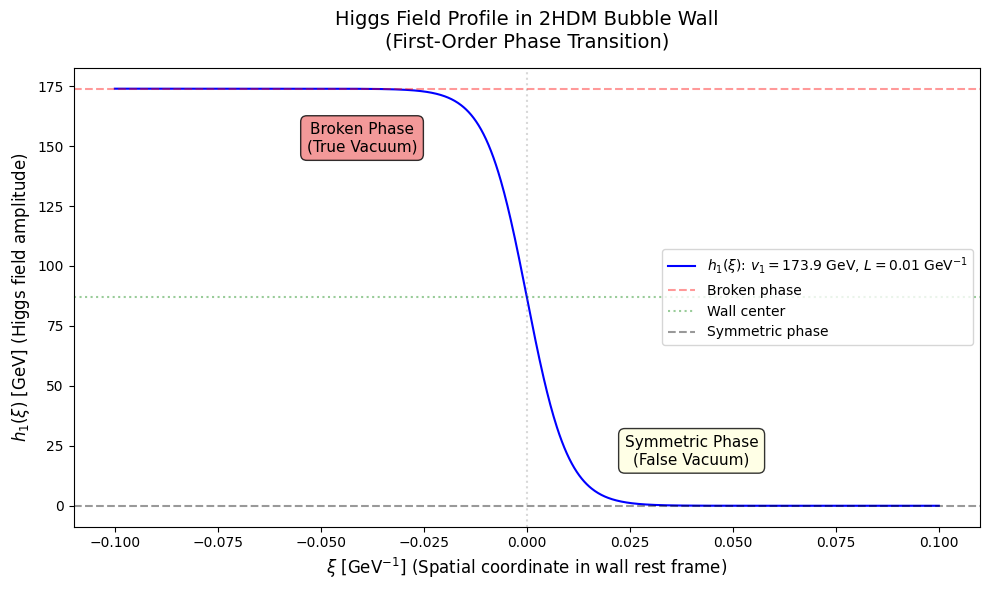

In [4]:
# CALCULATIONS

# Vectorized vacuum energy density calculations
rhoVac_values = np.array([calculate_rhoVac(v, vW, L, R0_values[i], beta, theta_cp_values[i]) 
                          for i in range(len(theta_cp_values))])
normalize_factors = np.array([calculate_normalize_factor(G, rhoVac, vW) for rhoVac in rhoVac_values])

# HIGGS FIELD PROFILE PLOT

# Create spatial coordinate array and calculate field profile
xi_range = np.linspace(-10*L, 10*L, 1000)
h1_values = hi(v1, xi_range, L)

# Create Higgs field plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(xi_range, h1_values, "b-", label=f"$h_1(\\xi)$: $v_1 = {v1:.4g}$ GeV, $L = {L:.3g}$ GeV$^{{-1}}$")

# Add reference lines
reference_lines = [
    (v1, "red", "--", "Broken phase"),
    (v1/2, "green", ":", "Wall center"),
    (0, "black", "--", "Symmetric phase")
]
for y_val, color, style, label in reference_lines:
    ax.axhline(y=y_val, color=color, linestyle=style, alpha=0.4, label=label)

ax.axvline(x=0, color="gray", linestyle=":", alpha=0.3)

# Add phase annotations
annotations = [
    ("Broken Phase\n(True Vacuum)", (-4*L, 0.85*v1), "lightcoral"),
    ("Symmetric Phase\n(False Vacuum)", (4*L, 0.1*v1), "lightyellow")
]
for text, (x, y), color in annotations:
    ax.annotate(text, xy=(x, y), fontsize=11, ha="center",
                bbox=dict(boxstyle="round,pad=0.4", facecolor=color, alpha=0.8))

# Format Higgs plot
ax.set_xlabel("$\\xi$ [GeV$^{-1}$] (Spatial coordinate in wall rest frame)", fontsize=12)
ax.set_ylabel("$h_1(\\xi)$ [GeV] (Higgs field amplitude)", fontsize=12)
ax.set_title("Higgs Field Profile in 2HDM Bubble Wall\n(First-Order Phase Transition)", 
            fontsize=14, pad=15)
ax.legend(fontsize=10, loc="center right")
plt.tight_layout()
plt.show()

Loading cached spectrum from gwscaled_d100_tau120.0_vW1_n500.pkl
Cache file loaded successfully. Keys: dict_keys(['omega_values', 'de_per_domega_values', 'd', 'tau', 'vW'])
Parameter validation - d: 100 vs 100, tau: 120.0 vs 120.0, vW: 1 vs 1
Omega arrays match: True, Parameters match: True
Successfully loaded cached spectrum data.


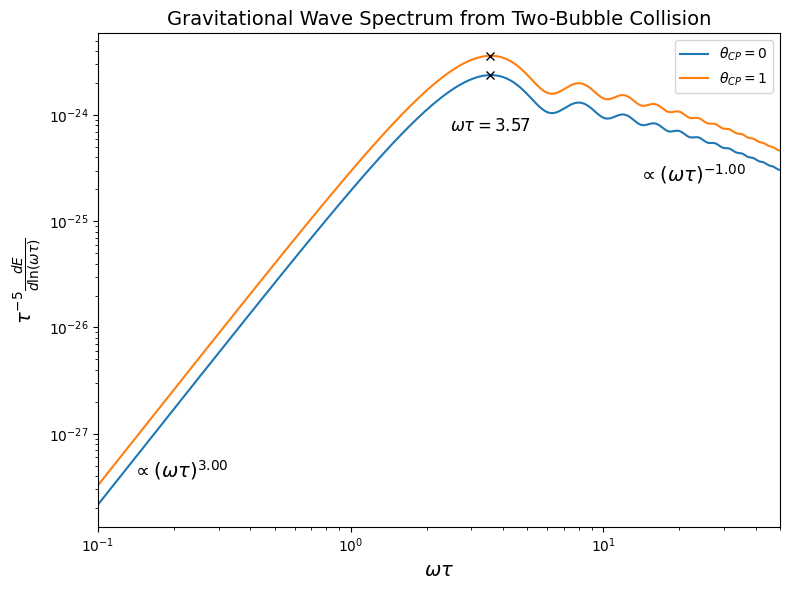

In [6]:
# GRAVITATIONAL WAVE SPECTRUM CALCULATION

# Frequency range setup
n_omega = 500
omega_min, omega_max = 0.1 / tau, 50.0 / tau
omega_values = np.logspace(np.log10(omega_min), np.log10(omega_max), n_omega)

# Cache management
cache_filename = f"gwscaled_d{d}_tau{tau:.1f}_vW{vW}_n{n_omega}.pkl"

# Load or compute spectrum
de_per_domega_values = None
if os.path.exists(cache_filename):
    print(f"Loading cached spectrum from {cache_filename}")
    try:
        with open(cache_filename, "rb") as f:
            cached_data = pickle.load(f)
        
        print(f"Cache file loaded successfully. Keys: {cached_data.keys()}")
        
        # Check if required keys exist
        required_keys = ["omega_values", "de_per_domega_values", "d", "tau", "vW"]
        missing_keys = [key for key in required_keys if key not in cached_data]
        if missing_keys:
            print(f"Missing keys in cache: {missing_keys}. Recomputing.")
        else:
            # Verify cache validity with tolerance for floating point comparison
            rtol = 1e-10
            omega_match = np.allclose(cached_data["omega_values"], omega_values, rtol=rtol)
            param_matches = (
                abs(cached_data["d"] - d) < rtol and
                abs(cached_data["tau"] - tau) < rtol and 
                abs(cached_data["vW"] - vW) < rtol
            )
            
            print(f"Parameter validation - d: {cached_data['d']} vs {d}, tau: {cached_data['tau']} vs {tau}, vW: {cached_data['vW']} vs {vW}")
            print(f"Omega arrays match: {omega_match}, Parameters match: {param_matches}")
            
            if omega_match and param_matches:
                de_per_domega_values = cached_data["de_per_domega_values"]
                print("Successfully loaded cached spectrum data.")
            else:
                print("Cached data mismatch. Recomputing.")
                if not omega_match:
                    print(f"Omega mismatch: cached length {len(cached_data['omega_values'])}, current length {len(omega_values)}")
                
    except FileNotFoundError:
        print(f"Cache file {cache_filename} not found. Recomputing.")
    except (KeyError, pickle.PickleError, EOFError) as e:
        print(f"Cache loading failed with error: {e}. Recomputing.")
    except Exception as e:
        print(f"Unexpected error loading cache: {e}. Recomputing.")
else:
    print(f"Cache file {cache_filename} does not exist. Computing from scratch.")

# Compute spectrum if needed
if de_per_domega_values is None:
    print("Computing gravitational wave spectrum.")
    de_per_domega_values = np.array([
        de_per_domega_unscaled(omega, vW, d, tau, show_progress=False) * omega**3
        for omega in tqdm(omega_values, desc="Computing GW spectrum")
    ])
    
    # Save to cache
    cache_data = {
        "omega_values": omega_values,
        "de_per_domega_values": de_per_domega_values,
        "d": d, "tau": tau, "vW": vW
    }
    with open(cache_filename, "wb") as f:
        pickle.dump(cache_data, f)
    print(f"Spectrum saved to {cache_filename}")

# DATA PROCESSING AND FILTERING

# Filter valid data points
valid_mask = np.isfinite(de_per_domega_values) & (de_per_domega_values > 0)
if not np.any(valid_mask):
    print("Warning: No valid data points found in spectrum.")

# Apply filtering
omega_values_filtered = omega_values[valid_mask]
de_per_domega_filtered = de_per_domega_values[valid_mask]

# Normalize spectra for different CP phases
normalized_spectra = tau**-5 * normalize_factors[:, np.newaxis] * de_per_domega_filtered[np.newaxis, :]

# POWER LAW ANALYSIS

omega_tau = omega_values_filtered * tau
n_points = len(omega_tau)
peak_idx = np.argmax(de_per_domega_filtered)

# Define fitting ranges (5% at start and end)
fit_fraction = 0.05
low_freq_end = max(3, int(fit_fraction * n_points))
high_freq_start = min(n_points - 3, int((1 - fit_fraction) * n_points))

# Perform power law fits
low_power, _ = fit_power_law(omega_tau[:low_freq_end], de_per_domega_filtered[:low_freq_end])
high_power, _ = fit_power_law(omega_tau[high_freq_start:], de_per_domega_filtered[high_freq_start:])

# SPECTRUM PLOTTING

fig, ax = plt.subplots(figsize=(8, 6))

# Plot spectra for different CP phases
spectrum_labels = [r"$\theta_{CP}=0$", f"$\\theta_{{CP}}={theta_cp_values[1]}$"]
plotted_values = []

for i, (spectrum, label) in enumerate(zip(normalized_spectra, spectrum_labels)):
    ax.loglog(omega_tau, spectrum, label=label)
    ax.loglog(omega_tau[peak_idx], spectrum[peak_idx], marker="x", color="black")
    plotted_values.append(spectrum)

# Add peak annotation
min_peak_value = min(spectrum[peak_idx] for spectrum in plotted_values)
ax.annotate(f"$\\omega\\tau={omega_tau[peak_idx]:.2f}$", 
            xy=(omega_tau[peak_idx], min_peak_value),
            xytext=(omega_tau[peak_idx], min_peak_value * 0.3),
            fontsize=12, ha="center")

# Add power law annotations
power_law_annotations = [
    (low_power, (0.05, 0.1), "lower left"),
    (high_power, (0.95, 0.7), "upper right")
]

for power, (x_pos, y_pos), position in power_law_annotations:
    if power is not None:
        ha = "right" if "right" in position else "left"
        ax.text(x_pos, y_pos, rf"$\propto (\omega\tau)^{{{power:.2f}}}$", 
                transform=ax.transAxes, fontsize=14, color="black", ha=ha)

# Format spectrum plot
ax.set_xlabel(r"$\omega\tau$", fontsize=14)
ax.set_ylabel(r"$\tau^{-5}\frac{dE}{d\ln(\omega\tau)}$", fontsize=14)
ax.set_title("Gravitational Wave Spectrum from Two-Bubble Collision", fontsize=14)
ax.set_xlim([omega_tau[0], omega_tau[-1]])
ax.legend(loc="best", fontsize=10)

plt.tight_layout()
plt.savefig("Figure/gwplot_twobubble.png", dpi=300, bbox_inches="tight")
plt.show()